## 1. Imports

In [114]:
import bisect
import collections
import datetime
import itertools
import nippy
import os
import random
import time
import warnings

warnings.filterwarnings('ignore')

import livelossplot
import matplotlib
import optuna
import pinard
import plotly
import sklearn
import tqdm

import kennard_stone     as ks
import numpy             as np
import pandas            as pd
import scipy             as sp
import tensorflow        as tf
import tensorflow_addons as tfa

In [116]:
from matplotlib             import pyplot as plt
from pinard.model_selection import train_test_split_idx
from scipy.signal           import savgol_filter
from scipy.spatial.distance import cdist
from sklearn                import linear_model
from tensorflow             import keras
from tqdm.keras             import TqdmCallback

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition       import PCA
from sklearn.metrics             import mean_squared_error
from sklearn.metrics             import r2_score
from sklearn.model_selection     import cross_val_predict
from sklearn.model_selection     import train_test_split
from sklearn.preprocessing       import StandardScaler

from keras.activations  import *
from keras.callbacks    import *
from keras.initializers import *
from keras.layers       import *
from keras.models       import *
from keras.optimizers   import *
from keras.regularizers import *

In [3]:
print('     livelossplot: version', livelossplot.__version__)
print('       matplotlib: version',   matplotlib.__version__)
print('           optuna: version',       optuna.__version__)
print('           pinard: version',       pinard.__version__)
print('           plotly: version',       plotly.__version__)
print('          sklearn: version',      sklearn.__version__)
print('             tqdm: version',         tqdm.__version__, '\n')

print('    kennard_stone: version',    ks.__version__)
print('            numpy: version',    np.__version__)
print('           pandas: version',    pd.__version__)
print('            scipy: version',    sp.__version__)
print('       tensorflow: version',    tf.__version__)
print('tensorflow_addons: version',   tfa.__version__)
print('            keras: version', keras.__version__)

     livelossplot: version 0.5.5
       matplotlib: version 3.5.2
           optuna: version 3.1.1
           pinard: version 0.9.7
           plotly: version 5.9.0
          sklearn: version 1.0.2
             tqdm: version 4.64.1 

    kennard_stone: version 1.1.2
            numpy: version 1.24.2
           pandas: version 1.4.4
            scipy: version 1.9.1
       tensorflow: version 2.12.0
tensorflow_addons: version 0.20.0
            keras: version 2.12.0


In [4]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
os.environ['PYTHONHASHSEED'] = '0'

plt.style.use('ggplot')
np.set_printoptions(precision=4, threshold=sys.maxsize, suppress=True, sign=' ', floatmode='fixed')

## 2. Help Functions
Questions to consider:
* How does MSC (with and without mean centering) differ from SNV?
* How does custom_train_test_split() differ from ks.train_test_split() and pinard.model_selection.train_test_split_idx(), for both KS and SPXY algorithm?

In [5]:
'''Return the current time as a string in YYYY/MM/DD HH:MM format.'''

def curr_time(): return datetime.datetime.now().strftime('%Y/%m/%d %H:%M')

In [6]:
'''
Multiplicative Scatter Correction
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python
https://d1wqtxts1xzle7.cloudfront.net/55227964/edited_dhanoa1994-libre.pdf?1512654247=&response-content-disposition=inline%3B+filename%3DThe_link_between_Multiplicative_Scatter.pdf&Expires=1681702610
&Signature=VGcZ~9Au96zKtJXgAQYQ9uBuQY4LwvarSgisttsUnW6CkQpGzukbUD88ie7vjSENtT6onGGknQo139qwZC03EBOMOFkc2T6HpLAsRRdGL-u-OaFwWw5jFKcQq1-q3BSbAPj2-ov9O~BV5fI7sBgsoWk19qnW7c6qWbO2n5Cu03vtnb04R53Blvco6mpR
LzQ7GQKNlANk1wk9EvMRc3ofv3a~B0BNIK81-OOS7XLs77nC0oDxZXuWz5jB6GAfCi-ns9NtAeo401biA7yIqCUEUyrhHOex~rND0HoC7-patTo7JQ2IDBfYKDq-vtENXqaIk2Jv9BlFob9aC6a7cIUHkA__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA
Yes, this is a long URL. But this is the only available link.
'''

def MSC(X, mean_center=True):
    
    if mean_center: X = np.array([row - row.mean() for row in X])
    
    X_msc = np.zeros(X.shape)
    X_ref = np.mean(X, axis=0)
    
    for i in range(X.shape[0]):
        
        a, b = np.polyfit(X_ref, X[i], 1)
        X_msc[i] = (X[i] - b) / a
    
    return X_msc

### Train-Test Splitting by Kennard-Stone Algorithm and SPXY Algorithm
* https://hxhc.xyz/post/kennardstone-spxy
* $d_  {KS}(i,j) = \sqrt{\sum_{k=1}^{m} (\mathbf{X}_{ik} - \mathbf{X}_{jk})^2}$
* $d_{SPXY}(i,j) = \sqrt{\sum_{k=1}^{m} (\mathbf{X}_{ik} - \mathbf{X}_{jk})^2} \big / \textrm{max}_{i,j \in [n]}
                   \sqrt{\sum_{k=1}^{m} (\mathbf{X}_{ik} - \mathbf{X}_{jk})^2} + ||y_i - y_j|| \big / \textrm{max}_{i,j \in [n]} ||y_i - y_j||$

In [7]:
def custom_train_test_split(X, Y, test_size, method):
    
    if method == 'KS': distance = cdist(X, X)
    
    if method == 'SPXY':
        
        Y = np.expand_dims(Y, axis=-1)
        
        distance_x  = cdist(X, X)
        distance_y  = cdist(Y, Y)
        
        distance_x /= distance_x.max()
        distance_y /= distance_y.max()
        
        distance    = distance_x + distance_y
    
    if 0 < test_size < 1: test_size = int(X.shape[0] * test_size)
    return max_min_distance_split(distance, X.shape[0] - test_size)

def max_min_distance_split(distance, train_size):
    
    i_train = []
    i_test  = [i for i in range(distance.shape[0])]
    
    first_2_points = np.unravel_index(np.argmax(distance), distance.shape)
    
    i_train.append(first_2_points[0])
    i_train.append(first_2_points[1])
    
    i_test.remove(first_2_points[0])
    i_test.remove(first_2_points[1])
    
    for _ in range(train_size - 2):
        
        max_min_dist_idx = np.argmax(np.min(distance[i_train,:], axis=0))
        
        i_train.append(max_min_dist_idx)
        i_test .remove(max_min_dist_idx)
    
    return i_train, i_test

In [51]:
def plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, plot=True):
    
    mse_train  = mean_squared_error(Y_train, Y_train_pred)
    mse_test   = mean_squared_error(Y_test , Y_test_pred)
    
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    
    r2_train   = r2_score(Y_train, Y_train_pred)
    r2_test    = r2_score(Y_test , Y_test_pred)
    
    r_train    = np.corrcoef(Y_train, Y_train_pred)[0,1]
    r_test     = np.corrcoef(Y_test , Y_test_pred)[0,1]
    
    if not plot: return mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test
    
    plt.figure(figsize=(8,8))
    
    x_min = np.concatenate([Y_train, Y_test]).min()
    x_max = np.concatenate([Y_train, Y_test]).max()
    
    ideal  = np.linspace(x_min, x_max, 2)
    fitted = np.polyval(np.polyfit(Y_test, Y_test_pred, 1), ideal)
    
    plt.scatter(Y_train, Y_train_pred, 8, 'pink')
    plt.scatter(Y_test , Y_test_pred , 8,  'red')
    
    plt.plot(ideal,  ideal, 'g', label= 'ideal')
    plt.plot(ideal, fitted, 'b', label='fitted')
    
    plt.text(0.10, 0.08, 'Training: MSE = %.4f' % mse_train + ', RMSE = %.4f' % rmse_train + ', $R^2$ = %.4f' % r2_train + ', $r_c$ = %.4f' % r_train, transform=plt.gca().transAxes)
    plt.text(0.10, 0.04, ' Testing: MSE = %.4f' % mse_test  + ', RMSE = %.4f' % rmse_test  + ', $R^2$ = %.4f' % r2_test  + ', $r_p$ = %.4f' % r_test , transform=plt.gca().transAxes)
    
    plt.xlabel( 'Measured Value')
    plt.ylabel('Predicted Value')
    
    plt.legend(loc='upper left')
    plt.title(curr_time())
    
    plt.show()
    
    return mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test

In [68]:
def plot_loss_and_prediction(history, Y_train, Y_train_pred, Y_test, Y_test_pred, plot=True):
    
    mse_train  = mean_squared_error(Y_train, Y_train_pred)
    mse_test   = mean_squared_error(Y_test , Y_test_pred)
    
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    
    r2_train   = r2_score(Y_train, Y_train_pred)
    r2_test    = r2_score(Y_test , Y_test_pred)
    
    r_train    = np.corrcoef(Y_train, Y_train_pred)[0,1]
    r_test     = np.corrcoef(Y_test , Y_test_pred)[0,1]
    
    if not plot: return mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test
    
    figure, axes = plt.subplots(1, 2, figsize=(20,8), squeeze=False)
    
    axes[0,0].plot(history.history[    'loss'], label='Calibration Loss')
    axes[0,0].plot(history.history['val_loss'], label=' Validation Loss')
    
    axes[0,0].set_yscale('log')
    axes[0,0].set_xlabel('Number of Epochs')
    axes[0,0].set_ylabel('Loss (log scale)')
    
    axis = axes[0,0].twinx()
    axis.plot(history.history['lr'], c='r', ls='--', label='   Learning Rate')
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
    
    x_min = np.concatenate([Y_train, Y_test]).min()
    x_max = np.concatenate([Y_train, Y_test]).max()
    
    ideal  = np.linspace(x_min, x_max, 2)
    fitted = np.polyval(np.polyfit(Y_test, Y_test_pred, 1), ideal)
    
    axes[0,1].scatter(Y_train, Y_train_pred, 8, 'pink')
    axes[0,1].scatter(Y_test , Y_test_pred , 8,  'red')
    
    axes[0,1].plot(ideal,  ideal, 'g', label= 'ideal')
    axes[0,1].plot(ideal, fitted, 'b', label='fitted')
    
    axes[0,1].text(0.10, 0.08, 'Training: MSE = %.4f' % mse_train + ', RMSE = %.4f' % rmse_train + ', $R^2$ = %.4f' % r2_train + ', $r_c$ = %.4f' % r_train, transform=axes[0,1].transAxes)
    axes[0,1].text(0.10, 0.04, ' Testing: MSE = %.4f' % mse_test  + ', RMSE = %.4f' % rmse_test  + ', $R^2$ = %.4f' % r2_test  + ', $r_p$ = %.4f' % r_test , transform=axes[0,1].transAxes)
    
    axes[0,1].set_xlabel( 'Measured Value')
    axes[0,1].set_ylabel('Predicted Value')
    
    axis.legend(loc=(0.76, 0.88))
    axes[0,0].legend(loc='upper right')
    axes[0,1].legend(loc='upper left')
    
    axes[0,0].set_title(curr_time())
    axes[0,1].set_title(curr_time())
    
    plt.show()
    
    return mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test

### Functions to implement the learning rate scheduler using OneCycleScheduler
* https://arxiv.org/pdf/1506.01186.pdf
* https://arxiv.org/pdf/1708.07120.pdf
* https://fastai1.fast.ai/callbacks.one_cycle
* https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle
* https://sgugger.github.io/the-1cycle-policy
* https://sgugger.github.io/how-do-you-find-a-good-learning-rate
* https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy
* https://www.kaggle.com/code/avanwyk/tf2-super-convergence-with-the-1cycle-policy/notebook

In [10]:
class CosineAnnealer:
    
    def __init__(self, start, end, max_steps):
        
        self.start     = start
        self.end       = end
        self.steps     = 0
        self.max_steps = max_steps
    
    def step(self):
        
        self.steps += 1
        cos = 1 - np.cos(np.pi * self.steps / self.max_steps)
        return self.start + (self.end - self.start) * cos / 2

class ExponentialAnnealer:
    
    def __init__(self, start, end, max_steps):
        
        self.start     = start
        self.end       = end
        self.steps     = 0
        self.max_steps = max_steps
    
    def step(self):
        
        self.steps += 1
        return self.start * (self.end / self.start) ** (self.steps / self.max_steps)

In [97]:
'''
Callback that schedules the learning rate on a one-cycle policy.
If the model supports a momentum parameter, it will also be adapted by the schedule.
The implementation adopts additional improvementsas per the fastai library.
Only two phases are used and the adaptation is done using cosine annealing.
In Phase 1, the learning rate increases from lr_max / div to lr_max and the momentum decreases from mom_max to mom_min.
In Phase 2, the learning rate decreases from lr_max to lr_max / div and the momentum increases from mom_min to mom_max.
By default, the phases are not of equal length, with Phase 1 percentage being controlled by phase_1_pct.
'''

class OneCycleScheduler(Callback):
    
    def __init__(self, lr_min=2**-16, lr_max=2**4, max_steps=2**10, phase_1_pct=0.25, mom_min=0.85, mom_max=0.95):
        
        super(OneCycleScheduler, self).__init__()
        
        phase_1_steps = max_steps * phase_1_pct
        phase_2_steps = max_steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        
        self.phase  = 0
        self.step   = 0
        
        self.lrs    = []
        self.moms   = []
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)],
                       [CosineAnnealer(lr_max, lr_min, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
    
    def on_train_begin(self, logs=None):
        
        self.set_lr      (self. lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
    
    def on_train_batch_begin(self, batch, logs=None):
        
        self. lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())
    
    def on_train_batch_end(self, batch, logs=None):
        
        self.step += 1
        if self.step == self.phase_1_steps: self.phase = 1
        
        self.set_lr      (self. lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
    
    def  lr_schedule(self): return self.phases[self.phase][0]
    def mom_schedule(self): return self.phases[self.phase][1]
    
    def get_lr      (self): return keras.backend.get_value(self.model.optimizer.learning_rate)
    def get_momentum(self): return keras.backend.get_value(self.model.optimizer.momentum)
    
    def set_lr      (self,  lr): keras.backend.set_value(self.model.optimizer.learning_rate,  lr)
    def set_momentum(self, mom): keras.backend.set_value(self.model.optimizer.momentum, mom)

In [88]:
'''
Callback that exponentially adjusts the learning rate after each training batch between lr_min and lr_max for max_steps number of batches.
The loss and learning rate are recorded at each step, allowing visually finding a good learning rate via plotting.
'''

class LRFinder(Callback):
    
    def __init__(self, lr_min=2**-16, lr_max=2**4, max_steps=2**10, smoothing=63/64):
        
        super(LRFinder, self).__init__()
        
        self.step        = 0
        self.avg_loss    = 0
        
        self.lrs         = []
        self.losses      = []
        
        self.max_steps   = max_steps
        self.smoothing   = smoothing
        
        self.lr_schedule = ExponentialAnnealer(lr_min, lr_max, max_steps)
    
    def on_train_begin(self, logs=None): self.set_lr(self.lr_schedule.start)
    
    def on_train_batch_end(self, batch, logs=None):
        
        self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * logs.get('loss')
        smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
        
        if smooth_loss >= 0.5: self.model.stop_training = True
        else:
            self.   lrs.append(self.get_lr())
            self.losses.append(smooth_loss)
        
        self.step += 1
        self.set_lr(self.lr_schedule.step())
    
    def get_lr(self): return keras.backend.get_value(self.model.optimizer.learning_rate)
    def set_lr(self, lr):    keras.backend.set_value(self.model.optimizer.learning_rate, lr)

## 3. Partial Least Squares (PLS) Regression

In [13]:
'''
Run PLS with a variable number of components (up to 16) and calculate MSE, RMSE, coefficient of determination (R-squared) & correlation coefficient (r).
https://nirpyresearch.com/partial-least-squares-regression-python
https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html
'''

def optimize_pls_components(X, Y, cv=4):
    
    mse  = []
    rmse = []
    r2   = []
    r    = []
    
    for n_components in range(1, 17):
        
        PLS = PLSRegression(n_components=n_components)
        Y_pred = cross_val_predict(PLS, X, Y, cv=cv).squeeze()
        
        mse .append(mean_squared_error(Y, Y_pred, squared=True))
        rmse.append(mean_squared_error(Y, Y_pred, squared=False))
        r2  .append(r2_score(Y, Y_pred))
        r   .append(np.corrcoef(Y, Y_pred)[0,1])
    
    return np.array(mse), np.array(rmse), np.array(r2), np.array(r)

In [14]:
def PLS(X_train, X_test, Y_train, Y_test, n_components, plot=True, return_coef=False):
    
    PLS = PLSRegression(n_components=n_components)
    PLS.fit(X_train, Y_train)
    
    Y_train_pred = PLS.predict(X_train).squeeze()
    Y_test_pred  = PLS.predict(X_test ).squeeze()
    
    if return_coef == True: return PLS.coef_
    if return_coef == False: return plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, plot=plot)

## 4. Principle Component Regression (PCR)

In [15]:
'''
Run PCR with a variable number of components (up to 16) and calculate MSE, RMSE, coefficient of determination (R-squared) & correlation coefficient (r).
https://nirpyresearch.com/principal-component-regression-python
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
'''

def optimize_pcr_components(X, Y, cv=4):
    
    mse  = []
    rmse = []
    r2   = []
    r    = []
    
    X = PCA().fit_transform(X)
    
    for n_components in range(1, 17):
        
        model = linear_model.LinearRegression()
        model.fit(X[:,:n_components], Y)
        Y_pred = cross_val_predict(model, X[:,:n_components], Y, cv=cv).squeeze()
        
        mse .append(mean_squared_error(Y, Y_pred, squared=True))
        rmse.append(mean_squared_error(Y, Y_pred, squared=False))
        r2  .append(r2_score(Y, Y_pred))
        r   .append(np.corrcoef(Y, Y_pred)[0,1])
    
    return np.array(mse), np.array(rmse), np.array(r2), np.array(r)

In [16]:
def PCR(X_train, X_test, Y_train, Y_test, n_components, plot=True):
    
    PCR = PCA(n_components=n_components)
    PCR.fit(X_train)
    
    X_train = PCR.transform(X_train)
    X_test  = PCR.transform(X_test)
    
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    
    Y_train_pred = model.predict(X_train).squeeze()
    Y_test_pred  = model.predict(X_test ).squeeze()
    
    return plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, plot=plot)

## 5. Data Acquisition & Pre-Processing

### 5.1. Data Acquisition

In [17]:
X   = pd.read_excel(  'data/lactate - 230209.xlsx', 0)             .iloc[1:,2:-1].to_numpy().astype(np.float64)
Y   = pd.read_excel(  'data/lactate - 230209.xlsx', 0)             .iloc[1:,  -1].to_numpy().astype(np.float64)
print('  Lactate 230209: X  = ' ,  X .shape, ', Y  = ' , Y .shape,                                   '\t\t\t\t %8.4f %8.4f %8.4f %8.4f'                     % (X .min(), X .max(), Y .min(), Y .max()))

X   = pd.read_excel(  'data/lactate - 221214.xlsx', 0)             .iloc[:,1:]   .to_numpy().astype(np.float64).T / 100
Y   = pd.read_excel(  'data/lactate - 221214.xlsx', 1)             .iloc[:,4 ]   .to_numpy().astype(np.float64)
WL  = pd.read_excel(  'data/lactate - 221214.xlsx', 0)             .iloc[:,0 ]   .to_numpy().astype(np.float64)
print('  Lactate 221214: X  = ' ,  X .shape, ', Y  = ' , Y .shape, ', WL = ', WL.shape,                  '\t\t %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f'         % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max()))

X   = pd.read_excel(  'data/lactate - 230222.xlsx', 0)             .iloc[:,1:-1] .to_numpy().astype(np.float64) / 100
Y   = pd.read_excel(  'data/lactate - 230222.xlsx', 0)             .iloc[:,  -1] .to_numpy().astype(np.float64)
WL  = pd.read_excel(        'data/wavelength.xlsx', 0, header=None).iloc[:,   1] .to_numpy().astype(np.float64)
print('  Lactate 230222: X  =  ',  X .shape, ', Y  =  ', Y .shape, ', WL = ', WL.shape,                  '\t\t %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f'         % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max()))

X   = pd.read_excel(  'data/lactate - 230410.xlsx', 0, header=None)              .to_numpy().astype(np.float64).T
Y   = pd.read_excel(  'data/lactate - 230410.xlsx', 1)             .iloc[:,5]    .to_numpy().astype(np.float64)
WL  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,3]    .to_numpy().astype(np.float64)
WN  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,1]    .to_numpy().astype(np.float64)
print('  Lactate 230410: X  ='  ,  X .shape, ', Y  = ' , Y .shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max(), WN.min(), WN.max()))

X0  = pd.read_excel('data/lactate - 23041600.xlsx', 1, header=None)              .to_numpy().astype(np.float64).T
X1  = pd.read_excel('data/lactate - 23041601.xlsx', 0, header=None)              .to_numpy().astype(np.float64).T
Y0  = pd.read_excel('data/lactate - 23041600.xlsx', 0)             .iloc[:,5]    .to_numpy().astype(np.float64)
Y1  = pd.read_excel('data/lactate - 23041601.xlsx', 1)             .iloc[:,5]    .to_numpy().astype(np.float64)
WL  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,3]    .to_numpy().astype(np.float64)
WN  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,1]    .to_numpy().astype(np.float64)
print('  Lactate 230416: X0 ='  ,  X0.shape, ', Y0 = ' , Y0.shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X0.min(), X0.max(), Y0.min(), Y0.max(), WL.min(), WL.max(), WN.min(), WN.max()))
print('  Lactate 230416: X1 ='  ,  X1.shape, ', Y1 = ' , Y1.shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X1.min(), X1.max(), Y1.min(), Y1.max(), WL.min(), WL.max(), WN.min(), WN.max()), '\n')

X   = pd.read_excel('data/hydration - 230209.xlsx', 0)             .iloc[1:,1:-1].to_numpy().astype(np.float64)
Y   = pd.read_excel('data/hydration - 230209.xlsx', 0)             .iloc[1:,  -1].to_numpy().astype(np.float64) * 2 - 3
unique, counts = np.unique(Y, return_counts=True)
print('Hydration 230209: X  = ' ,  X .shape, ', Y  = ' , Y .shape,                                   '\t\t\t\t %8.4f %8.4f %8.4f %8.4f'                     % (X .min(), X .max(), Y .min(), Y .max()),                               '\t\t\t\t\t', unique, counts)

X   = pd.read_excel('data/hydration - 230208.xlsx', 0, header=None)              .to_numpy().astype(np.float64).T / 100
Y   = pd.read_excel('data/hydration - 230208.xlsx', 1, header=None)              .to_numpy().astype(np.float64).squeeze()
WL  = pd.read_excel(  'data/lactate - 221214.xlsx', 0)             .iloc[:,0]    .to_numpy().astype(np.float64)
Y   = np.sign(Y)
unique, counts = np.unique(Y, return_counts=True)
print('Hydration 230208: X  = ' ,  X .shape, ', Y  = ' , Y .shape, ', WL = ', WL.shape,                  '\t\t %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f'         % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max()),                 '\t\t', unique, counts)

X   = pd.read_excel('data/hydration - 230303.xlsx', 0, header=None)              .to_numpy().astype(np.float64).T / 100
Y   = pd.read_excel('data/hydration - 230303.xlsx', 1, header=None).iloc[:,0]    .to_numpy().astype(np.float64) / 10
WL  = pd.read_excel(  'data/lactate - 221214.xlsx', 0)             .iloc[:,0]    .to_numpy().astype(np.float64)
unique, counts = np.unique(Y, return_counts=True)
print('Hydration 230303: X  ='  ,  X .shape, ', Y  ='  , Y .shape, ', WL = ', WL.shape,                  '\t\t %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f'         % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max()),                 '\t\t', unique, counts)

X1  = pd.read_excel('data/hydration - 230328.xlsx', 1, header=None)              .to_numpy().astype(np.float64).T
X2  = pd.read_excel('data/hydration - 230328.xlsx', 2, header=None)              .to_numpy().astype(np.float64).T
YY  = pd.read_excel('data/hydration - 230328.xlsx', 3)             .iloc[:65,:5] .to_numpy().astype(np.float64)
WL  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,3]    .to_numpy().astype(np.float64)
WN  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,1]    .to_numpy().astype(np.float64)
X   = np.concatenate([X1, X2])
Y   = np.concatenate([YY[:,0], YY[:,0]])
WT  = np.concatenate([YY[:,1], YY[:,2]])
USG = np.concatenate([YY[:,3], YY[:,4]])
unique, counts = np.unique(Y, return_counts=True)
print('Hydration 230328: X  ='  ,  X .shape, ', Y  = ' , Y .shape, ', WL =', WL.shape, ', WN =', WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max(), WN.min(), WN.max()), '\t', unique, counts, '\n')

X0  = pd.read_excel(  'data/alcohol - 230410.xlsx', 1, header=None)              .to_numpy().astype(np.float64).T
X1  = pd.read_excel(  'data/alcohol - 230410.xlsx', 2, header=None)              .to_numpy().astype(np.float64).T
X2  = pd.read_excel(  'data/alcohol - 230410.xlsx', 3, header=None)              .to_numpy().astype(np.float64).T
X3  = pd.read_excel(  'data/alcohol - 230410.xlsx', 4, header=None)              .to_numpy().astype(np.float64).T
Y0  = pd.read_excel(  'data/alcohol - 230410.xlsx', 0)             .iloc[: 91,1] .to_numpy().astype(np.float64)
Y1  = pd.read_excel(  'data/alcohol - 230410.xlsx', 0)             .iloc[:149,2] .to_numpy().astype(np.float64)
Y2  = pd.read_excel(  'data/alcohol - 230410.xlsx', 0)             .iloc[:188,3] .to_numpy().astype(np.float64)
Y3  = pd.read_excel(  'data/alcohol - 230410.xlsx', 0)             .iloc[:109,4] .to_numpy().astype(np.float64)
WL  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,3]    .to_numpy().astype(np.float64)
WN  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,1]    .to_numpy().astype(np.float64)
print('  Alcohol 230410: X0 = ' ,  X0.shape, ', Y0 =  ', Y0.shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X0.min(), X0.max(), Y0.min(), Y0.max(), WL.min(), WL.max(), WN.min(), WN.max()))
print('  Alcohol 230410: X1 ='  ,  X1.shape, ', Y1 = ' , Y1.shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X1.min(), X1.max(), Y1.min(), Y1.max(), WL.min(), WL.max(), WN.min(), WN.max()))
print('  Alcohol 230410: X2 ='  ,  X2.shape, ', Y2 = ' , Y2.shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X2.min(), X2.max(), Y2.min(), Y2.max(), WL.min(), WL.max(), WN.min(), WN.max()))
print('  Alcohol 230410: X3 ='  ,  X3.shape, ', Y3 = ' , Y3.shape, ', WL =' , WL.shape, ', WN =' , WN.shape, ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X3.min(), X3.max(), Y3.min(), Y3.max(), WL.min(), WL.max(), WN.min(), WN.max()))

  Lactate 230209: X  =  (137, 108) , Y  =  (137,) 				  -1.2807   1.4100   2.3000  15.8000
  Lactate 221214: X  =  (714, 512) , Y  =  (714,) , WL =  (512,) 		   0.0196   0.4216   0.8100  14.0100  899.6490 2107.4510
  Lactate 230222: X  =   (66, 470) , Y  =   (66,) , WL =  (470,) 		   0.0237   0.3503   0.9300  10.2100 1000.0250 2100.9760
  Lactate 230410: X  = (354, 1899) , Y  =  (354,) , WL = (1899,) , WN = (1899,)    0.0002   0.3148   0.9600  14.8000  866.2509 2530.3644  3952 11544
  Lactate 230416: X0 = (192, 1899) , Y0 =  (192,) , WL = (1899,) , WN = (1899,)    0.0002   0.2714   1.0000  10.9000  866.2509 2530.3644  3952 11544
  Lactate 230416: X1 = (507, 1899) , Y1 =  (507,) , WL = (1899,) , WN = (1899,)    0.0001   0.3148   0.9600  14.8000  866.2509 2530.3644  3952 11544 

Hydration 230209: X  =  (119, 108) , Y  =  (119,) 				  -1.2844   1.4212  -1.0000   1.0000 					 [-1.0000  1.0000] [65 54]
Hydration 230208: X  =  (210, 512) , Y  =  (210,) , WL =  (512,) 		   0.0272   0.4128  -1

In [18]:
X1  = pd.read_excel('data/hydration - 230328.xlsx', 1, header=None)              .to_numpy().astype(np.float64).T
X2  = pd.read_excel('data/hydration - 230328.xlsx', 2, header=None)              .to_numpy().astype(np.float64).T
YY  = pd.read_excel('data/hydration - 230328.xlsx', 3)             .iloc[:65,:5] .to_numpy().astype(np.float64)
WL  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,3]    .to_numpy().astype(np.float64)
WN  = pd.read_excel(        'data/wavelength.xlsx', 1, header=None).iloc[:,1]    .to_numpy().astype(np.float64)
X   = np.concatenate([X1, X2])
Y   = np.concatenate([YY[:,0], YY[:,0]])
WT  = np.concatenate([YY[:,1], YY[:,2]])
USG = np.concatenate([YY[:,3], YY[:,4]])
Y   = (USG - min(USG)) / (max(USG) - min(USG))
print('Hydration 230328: X  ='  ,  X .shape, ', Y  = ' , Y .shape, ', WL =', WL.shape, ', WN =', WN.shape, \
      ' %8.4f %8.4f %8.4f %8.4f %9.4f %9.4f %5d %5d' % (X .min(), X .max(), Y .min(), Y .max(), WL.min(), WL.max(), WN.min(), WN.max()))

Hydration 230328: X  = (130, 1899) , Y  =  (130,) , WL = (1899,) , WN = (1899,)    0.0003   0.2908   0.0000   1.0000  866.2509 2530.3644  3952 11544


In [19]:
X_orig = X
X_msc  = MSC(X)
X_std  = StandardScaler().fit_transform(X)
X_snv  = StandardScaler().fit_transform(X.T).T

print(X_orig.shape, X_msc.shape, X_std.shape, X_snv.shape, Y.shape, '\n')

print(np.array([np.mean(row) for row in X_orig[:5,:]]))
print(np.array([np.mean(row) for row in X_msc [:5,:]]))
print(np.array([np.mean(row) for row in X_std [:5,:]]))
print(np.array([np.mean(row) for row in X_snv [:5,:]]), '\n')

print(np.array([np. std(row) for row in X_orig[:5,:]]))
print(np.array([np. std(row) for row in X_msc [:5,:]]))
print(np.array([np. std(row) for row in X_std [:5,:]]))
print(np.array([np. std(row) for row in X_snv [:5,:]]), '\n')

print(np.array([np.mean(col) for col in X_orig[:,:5].T]))
print(np.array([np.mean(col) for col in X_msc [:,:5].T]))
print(np.array([np.mean(col) for col in X_std [:,:5].T]))
print(np.array([np.mean(col) for col in X_snv [:,:5].T]), '\n')

print(np.array([np. std(col) for col in X_orig[:,:5].T]))
print(np.array([np. std(col) for col in X_msc [:,:5].T]))
print(np.array([np. std(col) for col in X_std [:,:5].T]))
print(np.array([np. std(col) for col in X_snv [:,:5].T]))

(130, 1899) (130, 1899) (130, 1899) (130, 1899) (130,) 

[ 0.1240  0.1257  0.1249  0.1265  0.1255]
[ 0.0000  0.0000  0.0000  0.0000  0.0000]
[ 0.0815  0.5018  0.2665  0.5931  0.4532]
[ 0.0000  0.0000  0.0000 -0.0000 -0.0000] 

[ 0.0974  0.0981  0.0979  0.0987  0.0979]
[ 0.0940  0.0940  0.0940  0.0940  0.0940]
[ 0.4734  0.3001  0.4139  0.3439  0.3248]
[ 1.0000  1.0000  1.0000  1.0000  1.0000] 

[ 0.2599  0.2599  0.2598  0.2597  0.2596]
[ 0.1385  0.1384  0.1383  0.1383  0.1382]
[ 0.0000  0.0000  0.0000  0.0000  0.0000]
[ 1.4726  1.4718  1.4710  1.4702  1.4692] 

[ 0.0157  0.0157  0.0157  0.0157  0.0157]
[ 0.0023  0.0023  0.0023  0.0023  0.0023]
[ 1.0000  1.0000  1.0000  1.0000  1.0000]
[ 0.0246  0.0246  0.0245  0.0244  0.0246]


### 5.2. Data Pre-Processing Optimization

### 5.3. Data Pre-Processing & Train-Test Splitting

(130, 1899) (130,)
(96, 1899) (96,)
(34, 1899) (34,)
(64, 1899) (64,)
(32, 1899) (32,) 



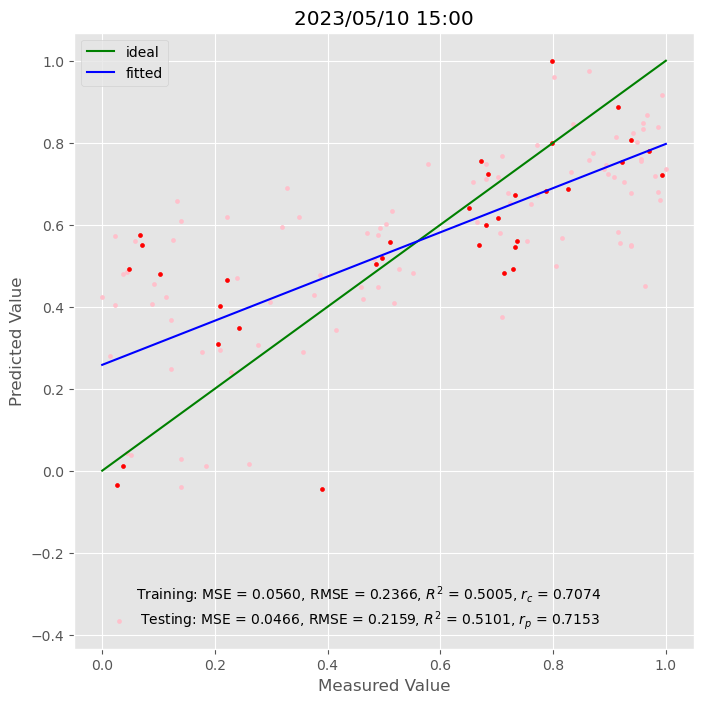

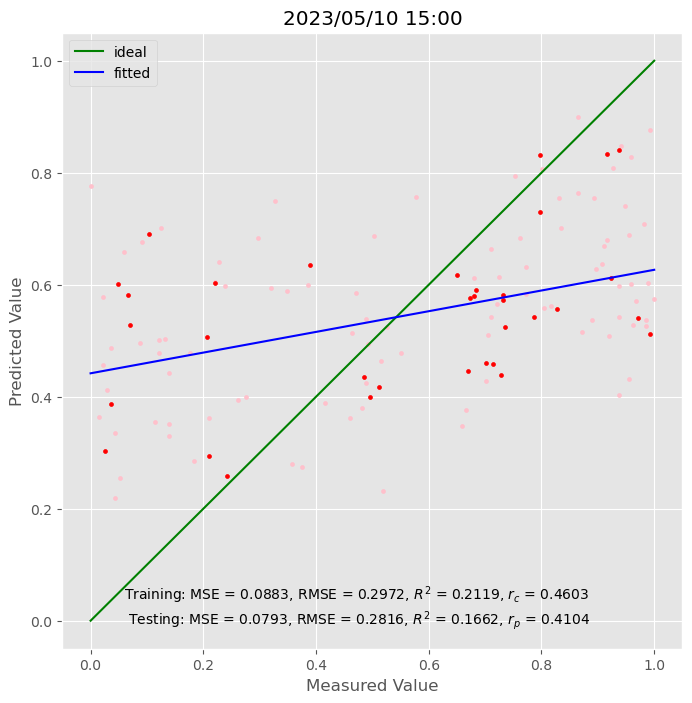

In [20]:
X = savgol_filter(X_snv, window_length=11, polyorder=1, deriv=0)
Y = Y

i_train, i_test = custom_train_test_split(X, Y, test_size=34, method='SPXY')
X_train, X_test, Y_train, Y_test = X[i_train], X[i_test], Y[i_train], Y[i_test]

i_calib, i_valid = custom_train_test_split(X_train, Y_train, test_size=32, method='SPXY')
X_calib, X_valid, Y_calib, Y_valid = X_train[i_calib], X_train[i_valid], Y_train[i_calib], Y_train[i_valid]

print(X      .shape, Y      .shape)
print(X_train.shape, Y_train.shape)
print(X_test .shape, Y_test .shape)
print(X_calib.shape, Y_calib.shape)
print(X_valid.shape, Y_valid.shape, '\n')

mse, rmse, r2, r = optimize_pls_components(X_train, Y_train)
PLS(X_train, X_test, Y_train, Y_test, 8);

mse, rmse, r2, r = optimize_pcr_components(X_train, Y_train)
PCR(X_train, X_test, Y_train, Y_test, 8);

## 6. Variable Selection

### 6.1. Successive Projection Algorithm (SPA)
* https://www.sciencedirect.com/science/article/pii/S0169743901001198
* https://www.sciencedirect.com/science/article/pii/S0165993612002750
* Given $\mathbf{X} \in \mathbb{R}^{m \times n}$ and $\mathbf{x}_i, \mathbf{x}_j \in \mathbb{R}^m$, where $m$ is the number of samples and $n$ is the number of variables:
* The projection of $\mathbf{x}_j$ onto the orthogonal subspace of $\mathbf{x}_i$ is
$\mathbf{P}(\mathbf{x}_j) = \mathbf{x}_j - (\mathbf{x}_j ^ \intercal \cdot \mathbf{x}_i) \cdot \mathbf{x}_i \cdot (\mathbf{x}_i ^ \intercal \cdot \mathbf{x}_i) ^ {-1}$
* The projection of $\mathbf{x}$ onto the orthogonal subspace of $\mathbf{X}$ is
$\mathbf{P}(\mathbf{x}) = \big ( \mathbf{I} - \mathbf{X} \cdot (\mathbf{X} ^ \intercal \cdot \mathbf{X}) ^ {-1} \cdot \mathbf{X} ^ \intercal \big ) \cdot \mathbf{x}$,
* with norm $\big \lVert \mathbf{P}(\mathbf{x}) \big \rVert ^ 2
= \mathbf{x} ^ \intercal \cdot \mathbf{P}(\mathbf{x})
= \mathbf{x} ^ \intercal \cdot \big ( \mathbf{I} - \mathbf{X} \cdot (\mathbf{X} ^ \intercal \cdot \mathbf{X}) ^ {-1} \cdot \mathbf{X} ^ \intercal \big ) \cdot \mathbf{x}$

In [21]:
def SPA(X, i_init, method=0):
    
    m = X.shape[0]
    n = X.shape[1]
    
    X = np.array(X)
    XO = [X[:,i_init]]
    
    i_select = []
    i_remain = [i for i in range(n)]
    n_select = []
    
    i_select.append(i_init)
    i_remain.remove(i_init)
    n_select.append(np.linalg.norm(XO[0]))
    
    for _ in range(min(m, n) - 1):
        
        i_max = -1
        n_max = -1
        XT = np.array(XO).T
        
        for j in i_remain:
            
            if method == 0:
                
                xi = XT[:,-1]
                xj = X[:,j]
                
                proj = xj - xi * np.dot(xi, xj) / np.dot(xi, xi)
                norm = np.linalg.norm(proj)
            
            if method == 1:
                
                x = X[:,j]
                
                proj = (np.identity(m) - XT @ np.linalg.inv(XT.T @ XT) @ XT.T) @ x
                norm = x.T @ proj
            
            X[:,j] = proj
            if norm > n_max: i_max, n_max = j, norm
        
        XO.append(X[:,i_max])
        i_select.append(i_max)
        i_remain.remove(i_max)
        n_select.append(n_max)
    
    return i_select, n_select

### 6.2. Uninformative Variable Elimination (UVE)
* https://pubs.acs.org/doi/full/10.1021/ac960321m
* https://www.sciencedirect.com/science/article/pii/S0169743907001980

In [22]:
def UVE(X, Y):
    
    m = X.shape[0]
    n = X.shape[1]
    B = []
    
    counter = [0] * 16
    for cv in range(2, 17):
        mse, rmse, r2, r = optimize_pls_components(X, Y, cv)
        counter[np.argmax(r2)] += 1
    n_components = np.argmax(counter) + 1
    
    for i in range(m):
        
        X_train = np.concatenate([X[:i], X[i+1:]])
        Y_train = np.concatenate([Y[:i], Y[i+1:]])
        
        X_test = np.expand_dims(X[i], axis=0)
        Y_test = np.expand_dims(Y[i], axis=0)
        
        coef = PLS(X_train, X_test, Y_train, Y_test, n_components, plot=False, return_coef=True)
        B.append(coef.squeeze())
    
    B = np.array(B).T
    mean = np.array([np.mean(row) for row in B])
    std  = np.array([np.std (row) for row in B])
    c = mean / std
    
    plt.figure(figsize=(8,8))
    plt.plot(c)
    plt.xticks(range(0,2000,100))
    plt.show()
    
    return c

180 130


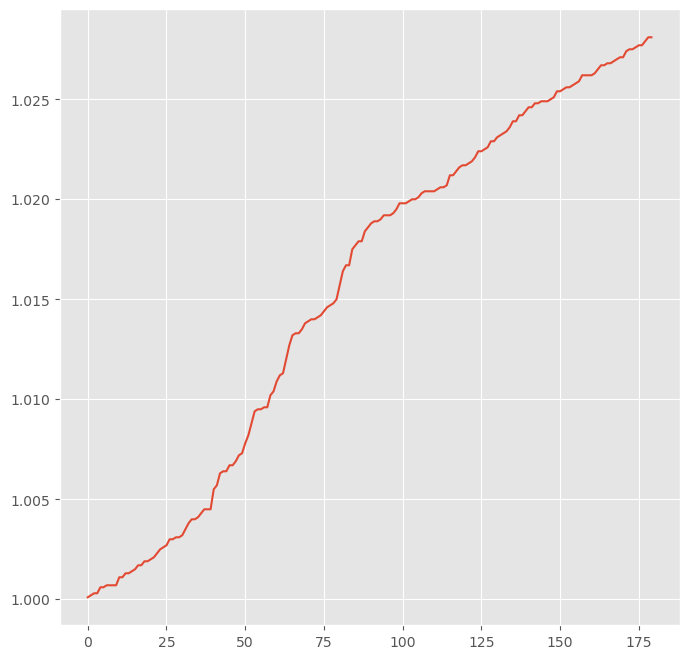

In [23]:
nums = [1.0257, 1.0262, 1.0226, 1.0094, 1.0023, 1.0020, 1.0043,
        1.0025, 1.0026, 1.0031, 1.0067, 1.0135, 1.0140, 1.0045,
        1.0164, 1.0184, 1.0193, 1.0190, 1.0192, 1.0198, 1.0198,
        1.0200, 1.0254, 1.0265, 1.0277, 1.0275, 1.0271, 1.0262,
        1.0109, 1.0188, 1.0205, 1.0229,
        1.0104, 1.0139, 1.0141, 1.0157,
        1.0140, 1.0019, 1.0013, 1.0038, 1.0120, 1.0148,
        1.0073, 1.0021, 1.0014, 1.0015, 1.0017, 1.0019,
        1.0276, 1.0274, 1.0256, 1.0203, 1.0217, 1.0212,
        1.0040, 1.0032, 1.0035, 1.0069, 1.0112, 1.0113,
        1.0242, 1.0217, 1.0268, 1.0234, 1.0221, 1.0224, 1.0232,
        1.0242, 1.0251, 1.0270, 1.0275, 1.0269, 1.0262, 1.0244,
        1.0249, 1.0279, 1.0258, 1.0255, 1.0233, 1.0214,
        1.0064, 1.0132, 1.0147, 1.0138, 1.0146, 1.0142,
        1.0225, 1.0224, 1.0256, 1.0268, 1.0277, 1.0262, 1.0267, 1.0263, 1.0250,
        1.0102, 1.0206, 1.0204, 1.0192, 1.0192, 1.0201, 1.0207, 1.0206, 1.0200,
        1.0267, 1.0259, 1.0189, 1.0186, 1.0199,
        1.0057, 1.0040, 1.0055, 1.0045, 1.0067,
        1.0144, 1.0088, 1.0013, 1.0007, 1.0041, 1.0096, 1.0133, 1.0150,
        1.0078, 1.0045, 1.0011, 1.0017, 1.0063, 1.0072, 1.0064, 1.0082,
        1.0175, 1.0198, 1.0204, 1.0204, 1.0204,
        1.0096, 1.0177, 1.0133, 1.0095, 1.0095,
        1.0218, 1.0219, 1.0229, 1.0236, 1.0231, 1.0216, 1.0179, 1.0031, 1.0007, 1.0001,
        1.0254, 1.0271, 1.0212, 1.0179, 1.0189, 1.0195, 1.0127, 1.0027, 1.0011, 1.0002,
        1.0281, 1.0249, 1.0239, 1.0248, 1.0246, 1.0167, 1.0030, 1.0006, 1.0003, 1.0007,
        1.0281, 1.0249, 1.0239, 1.0248, 1.0246, 1.0167, 1.0030, 1.0006, 1.0003, 1.0007]

vals = [ 0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
         0,  0,  0,  0,
         0,  0,  0,  0,
         1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,
         0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
         1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1,
         0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,
         1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1]

print(len(nums), len(vals))
plt.figure(figsize=(8,8))
plt.plot(sorted(nums))
plt.show()

## 7. Basic One-Dimensional Convolutional Neural Network (1D CNN) Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1899, 1)]         0         
                                                                 
 conv1a (Conv1D)             (None, 1899, 4)           24        
                                                                 
 flatten (Flatten)           (None, 7596)              0         
                                                                 
 dense1 (Dense)              (None, 256)               1944832   
                                                                 
 dense2 (Dense)              (None, 16)                4112      
                                                                 
 outputs (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,948,985
Trainable params: 1,948,985
Non-train

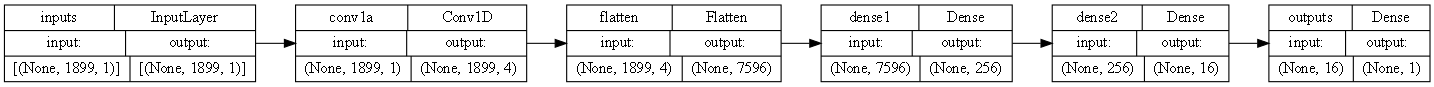

In [24]:
'''OH MY FREAKING GOD'''
'''EVEN THOUGH IT IS A BASIC MODEL SIMPLY FOR THE PURPOSE OF LEARNING RATE RANGE TEST'''
'''THERE ARE STILL SO MANY FUCKING HYPER-PARAMETERS TO DEFINE'''

def make_model(input_shape=(1899,1)):
    
    K_NUMBER   =   4
    K_WIDTH    =   5
    K_STRIDE   =   1
    
    DENSE1_DIM = 256
    DENSE2_DIM =  16
    OUTPUT_DIM =   1
    
    K_INIT     = HeNormal(seed=0)
    K_REG      = L2(2 ** -8)
    DROPOUT    = 2 ** -4
    
    activ      = ReLU()
    
    inputs     = Input(input_shape, name='inputs')
    conv1a     = Conv1D(K_NUMBER, K_WIDTH, K_STRIDE, 'same', activation=activ, name='conv1a')(inputs)
    flatten    = Flatten(name='flatten')(conv1a)
    
    dense1     = Dense(DENSE1_DIM, activation=activ   , name='dense1' )(flatten)
    dense2     = Dense(DENSE2_DIM, activation=activ   , name='dense2' )(dense1)
    outputs    = Dense(OUTPUT_DIM, activation='linear', name='outputs')(dense2)
    
    return Model(inputs, outputs, name='model')

model = make_model()
print(model.summary())
keras.utils.plot_model(model, show_shapes=True, rankdir='LR', dpi=80)

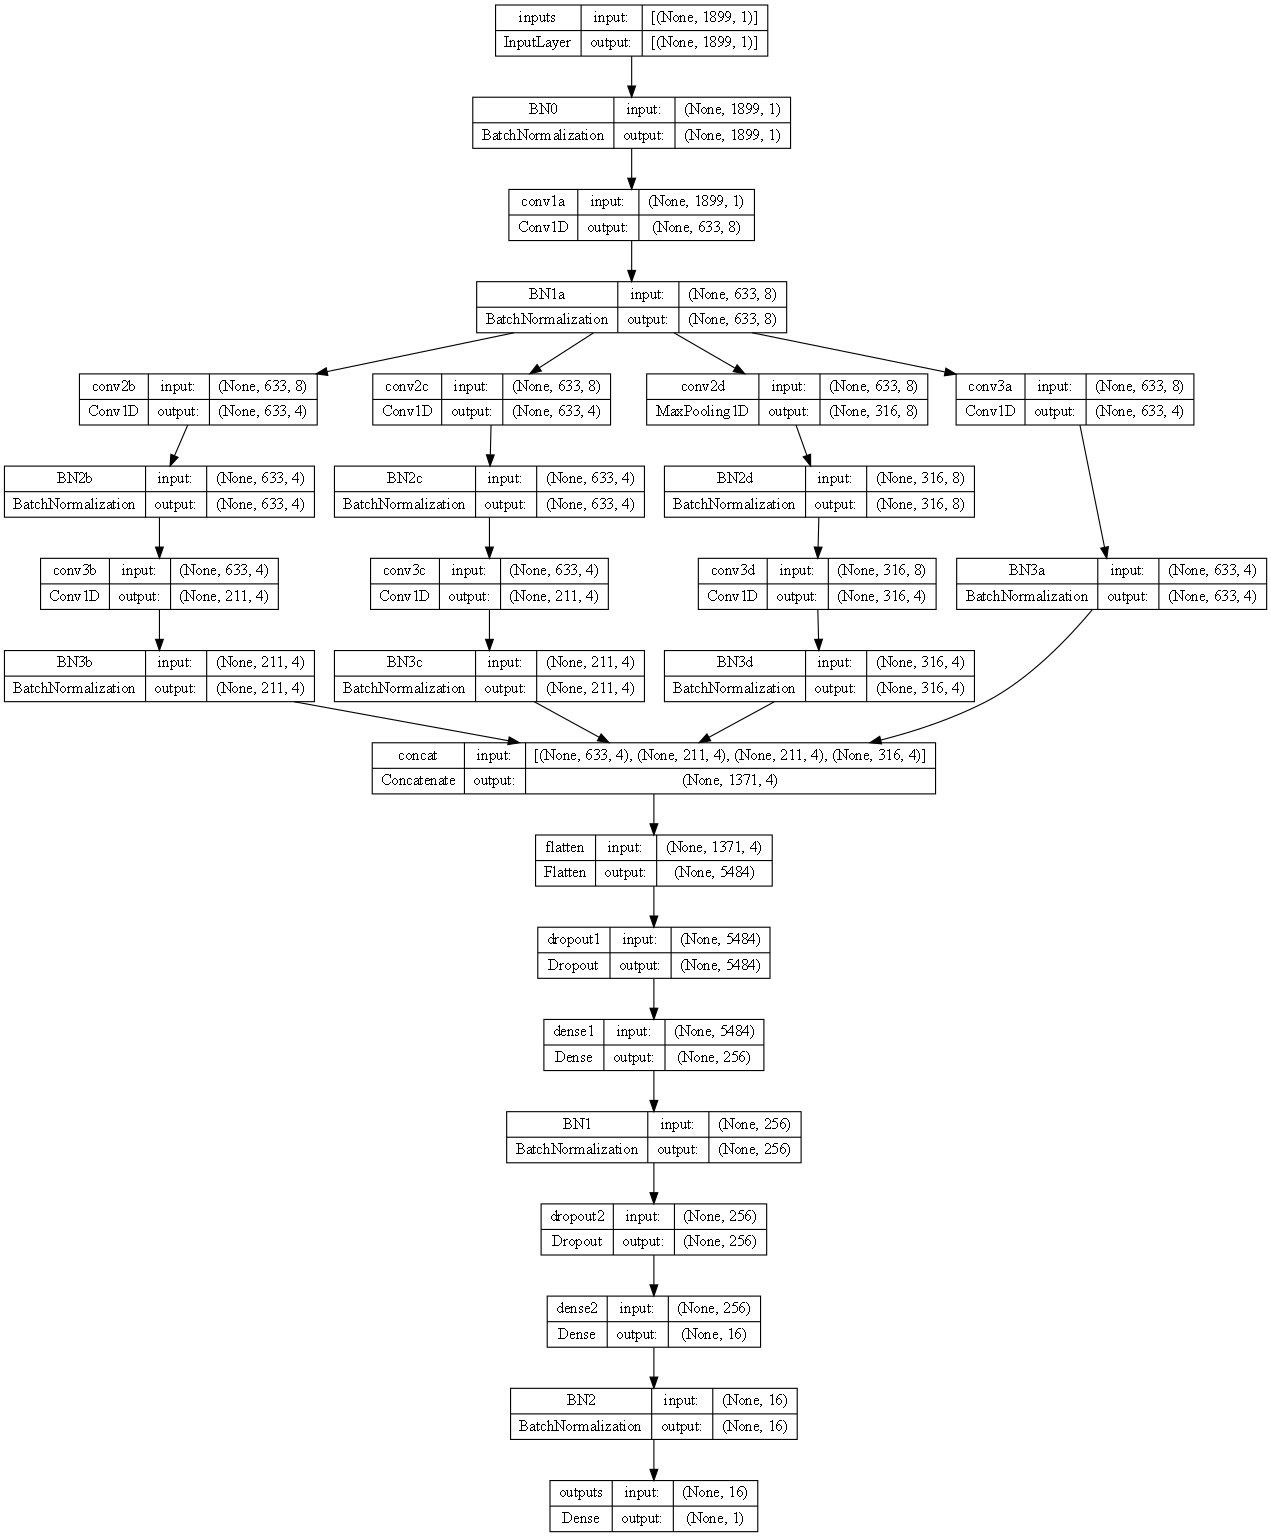

In [130]:
'''https://www.sciencedirect.com/science/article/pii/S0003267019300169'''

def make_model(input_shape=(1899,1)):
    
    K_NUMBER_1   = 8
    K_NUMBER_2   = 4
    K_NUMBER_3   = 4
    
    K_WIDTH_1    = 7 # 7, 5, 7, 9
    K_WIDTH_2    = 3 # 3, 2, 3, 5
    K_WIDTH_3    = 5 # 5, 3, 5, 7
    
    K_STRIDE_1   = 3 # 3, 3, 3, 5
    K_STRIDE_2   = None
    K_STRIDE_3   = 2 # 2, 2, 2, 3
    
    DENSE1_DIM   = 256
    DENSE2_DIM   =  16
    OUTPUT_DIM   =   1
    
    DROPOUT_1    = 4 / 16
    DROPOUT_2    = 3 / 16
    
    K_INIT       = HeNormal(seed=0)
    K_REG        = L2(0.001) # 0.001, 0.001, 0.01, 0.01
    
    activ        = LeakyReLU()
    
    inputs       = Input(input_shape, name='inputs')
    batch_norm0  = BatchNormalization(name='BN0')(inputs)
    
    conv1a       = Conv1D(K_NUMBER_1, K_WIDTH_1, K_STRIDE_1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv1a')(batch_norm0)
    batch_norm1a = BatchNormalization(name='BN1a')(conv1a)
    
    conv2a       = None
    conv2b       = Conv1D(K_NUMBER_2, 1, 1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv2b')(batch_norm1a)
    conv2c       = Conv1D(K_NUMBER_2, 1, 1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv2c')(batch_norm1a)
    conv2d       = MaxPool1D(name='conv2d')(batch_norm1a)
    
    batch_norm2a = None
    batch_norm2b = BatchNormalization(name='BN2b')(conv2b)
    batch_norm2c = BatchNormalization(name='BN2c')(conv2c)
    batch_norm2d = BatchNormalization(name='BN2d')(conv2d)
    
    conv3a       = Conv1D(K_NUMBER_3, 1, 1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv3a')(batch_norm1a)
    conv3b       = Conv1D(K_NUMBER_3, K_WIDTH_1, K_STRIDE_1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv3b')(batch_norm2b)
    conv3c       = Conv1D(K_NUMBER_3, K_WIDTH_1, K_STRIDE_1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv3c')(batch_norm2c)
    conv3d       = Conv1D(K_NUMBER_3, 1, 1, 'same', activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='conv3d')(batch_norm2d)
    
    batch_norm3a = BatchNormalization(name='BN3a')(conv3a)
    batch_norm3b = BatchNormalization(name='BN3b')(conv3b)
    batch_norm3c = BatchNormalization(name='BN3c')(conv3c)
    batch_norm3d = BatchNormalization(name='BN3d')(conv3d)
    
    concat       = Concatenate(axis=1, name='concat')([batch_norm3a, batch_norm3b, batch_norm3c, batch_norm3d])
    flatten      = Flatten(name='flatten')(concat)
    
    dropout1     = Dropout(DROPOUT_1, name='dropout1')(flatten)
    dense1       = Dense(DENSE1_DIM, activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='dense1')(dropout1)
    batch1       = BatchNormalization(name='BN1')(dense1)
    
    dropout2     = Dropout(DROPOUT_2, name='dropout2')(batch1)
    dense2       = Dense(DENSE2_DIM, activation=activ, kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='dense2')(dropout2)
    batch2       = BatchNormalization(name='BN2')(dense2)
    
    outputs      = Dense(OUTPUT_DIM, activation='linear', kernel_initializer=K_INIT, kernel_regularizer=K_REG, name='outputs')(batch2)
    
    model        = Model(inputs, outputs, name='model')
    
    return model

model = make_model()
keras.utils.plot_model(model, show_shapes=True, dpi=80)

## 8. Learning Rate Range Test

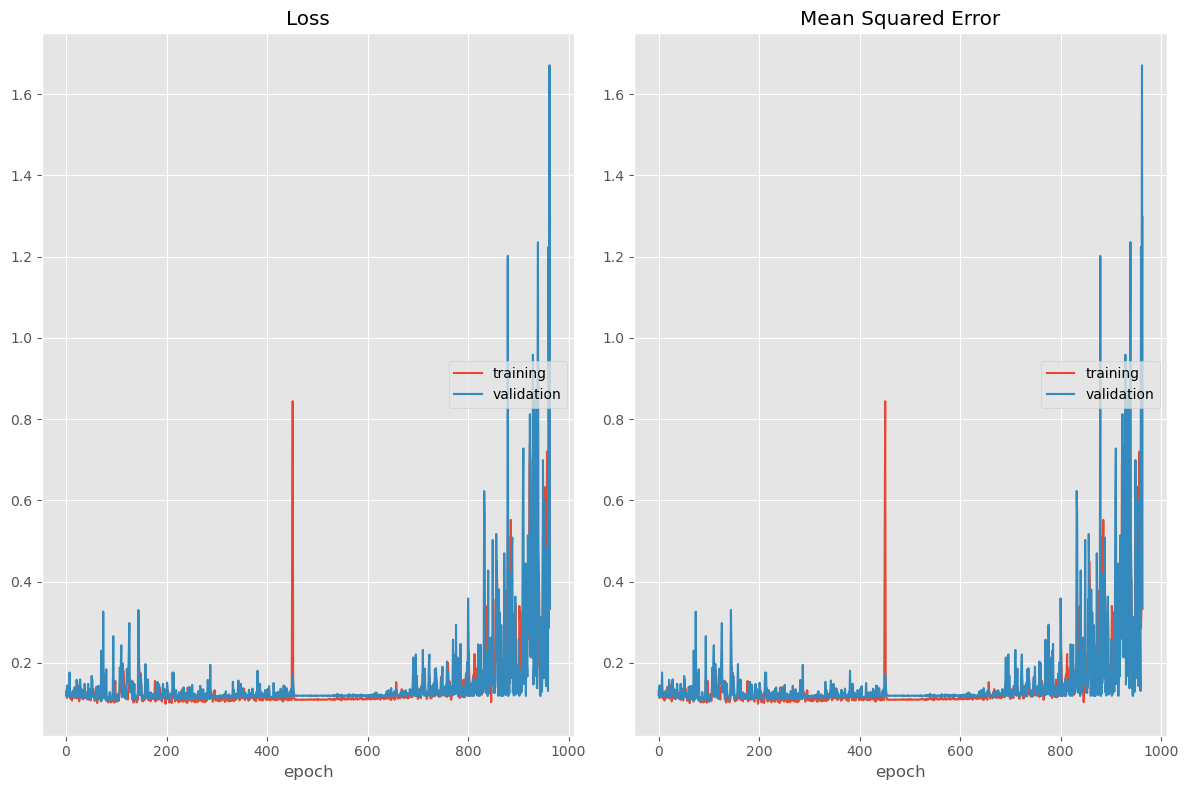

Loss
	training         	 (min:    0.099, max:    1.298, cur:    1.298)
	validation       	 (min:    0.108, max:    1.671, cur:    0.333)
Mean Squared Error
	training         	 (min:    0.099, max:    1.298, cur:    1.298)
	validation       	 (min:    0.108, max:    1.671, cur:    0.333)
16/16 [==============================] - 1s 34ms/step - loss: 1.2984 - mse: 1.2984 - val_loss: 0.3329 - val_mse: 0.3329


In [98]:
keras.backend.clear_session()

batch_size = 2 **  2
epochs     = 2 ** 10

steps_per_epoch = int(np.ceil(X_calib.shape[0] / batch_size))
max_steps = steps_per_epoch * epochs

model = make_model()
model.compile(optimizer=Adam(), loss='mse', metrics=['mse'])

check_point = ModelCheckpoint(filepath='model.h5', save_best_only=True)
one_cycle   = OneCycleScheduler(max_steps=max_steps, phase_1_pct=1)
lr_finder   = LRFinder(max_steps=max_steps)
plot_losses = livelossplot.PlotLossesKerasTF()

history = model.fit(X_calib, Y_calib, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_valid), callbacks=[check_point, lr_finder, plot_losses], verbose=True)

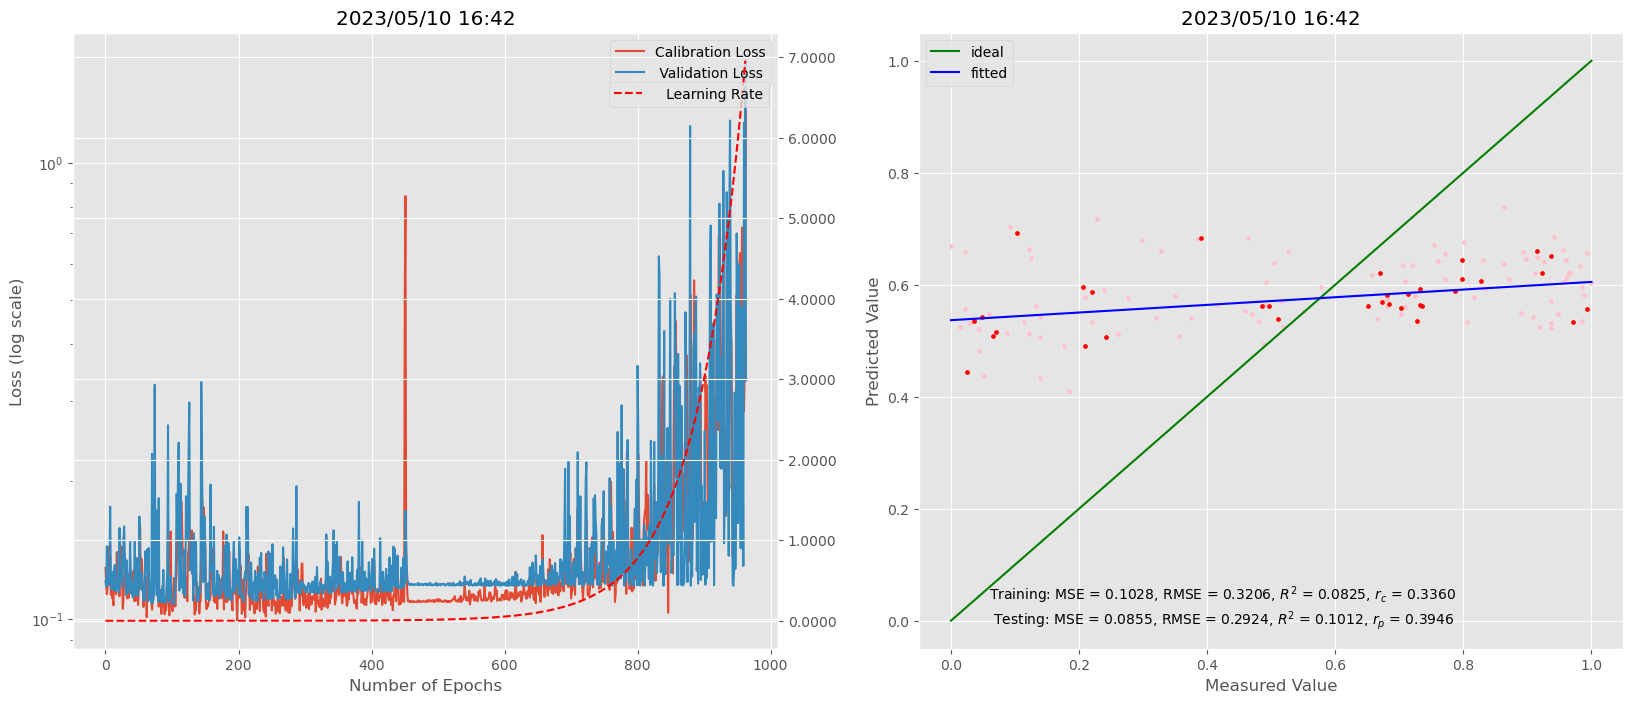

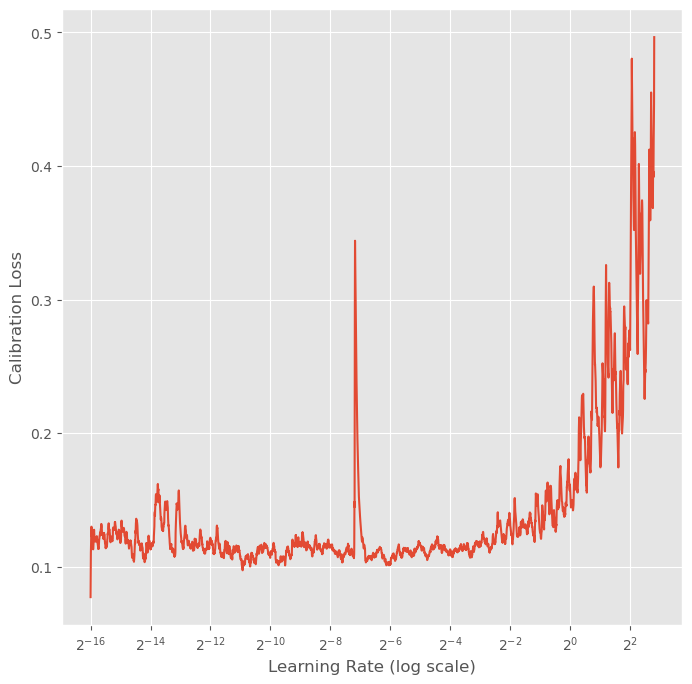

In [102]:
model.load_weights('model.h5')

Y_calib_pred = model(X_calib, training=False).numpy().squeeze()
Y_valid_pred = model(X_valid, training=False).numpy().squeeze()
Y_train_pred = model(X_train, training=False).numpy().squeeze()
Y_test_pred  = model(X_test , training=False).numpy().squeeze()

if 'lr' not in history.history:
    k, lrs = steps_per_epoch, []
    for i in range(len(history.history['loss']) - 1): lrs.append(sum(lr_finder.lrs[i*k:i*k+k]) / k)
    history.history['lr'] = lrs

plot_loss_and_prediction(history, Y_train, Y_train_pred, Y_test, Y_test_pred);

plt.figure(figsize=(8,8))
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale('log', base=2)
plt.xticks([2 ** k for k in range(-16, int(math.log2(lr_finder.lrs[-1])) + 2, 2)])
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Calibration Loss')
plt.show()

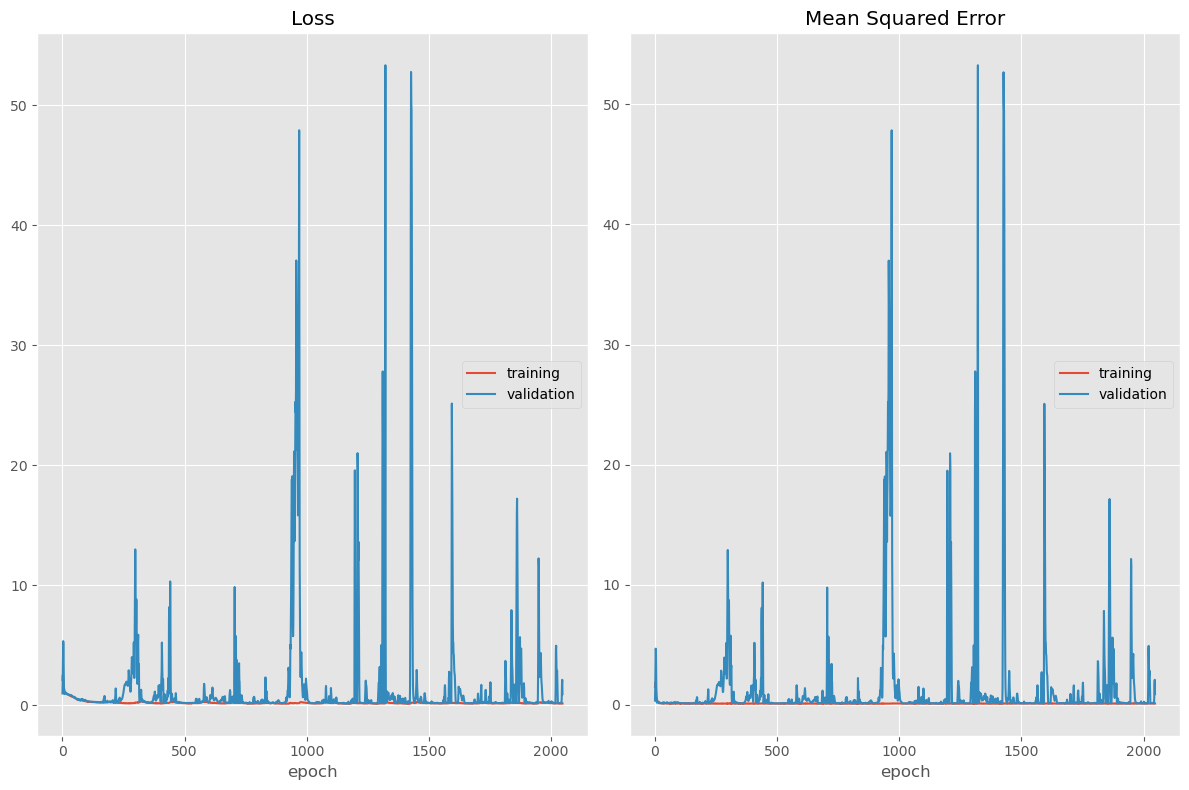

Loss
	training         	 (min:    0.104, max:    2.477, cur:    0.129)
	validation       	 (min:    0.124, max:   53.324, cur:    0.910)
Mean Squared Error
	training         	 (min:    0.078, max:    1.863, cur:    0.102)
	validation       	 (min:    0.096, max:   53.262, cur:    0.883)
4/4 [==============================] - 0s 159ms/step - loss: 0.1293 - mse: 0.1020 - val_loss: 0.9100 - val_mse: 0.8826


In [141]:
scale_factor  = 7 / 8
lr_min        = 2 ** -10
lr_max        = 2 ** - 6
step_size     = 2 **   8
learning_rate = 2 ** - 8
batch_size    = 2 **   4
epochs        = 2 **  11

CLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=lr_min, maximal_learning_rate=lr_max, scale_fn=lambda x: scale_factor**(x-1), step_size=step_size)
optimizer = Adam(CLR)

check_point = ModelCheckpoint(filepath='model.h5', save_best_only=True)
increase_lr = ReduceLROnPlateau(monitor='val_mse', factor=2**-7, patience=2**12, min_lr=2**-10)
decrease_lr = ReduceLROnPlateau(monitor='val_mse', factor=2**-1, patience=2** 9, min_lr=2**-10)
early_stop  = EarlyStopping(monitor='val_mse', patience=2**12, restore_best_weights=True)
plot_losses = livelossplot.PlotLossesKerasTF()

model = make_model()
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
history = model.fit(X_calib, Y_calib, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_valid), callbacks=[check_point, early_stop, plot_losses], verbose=1)

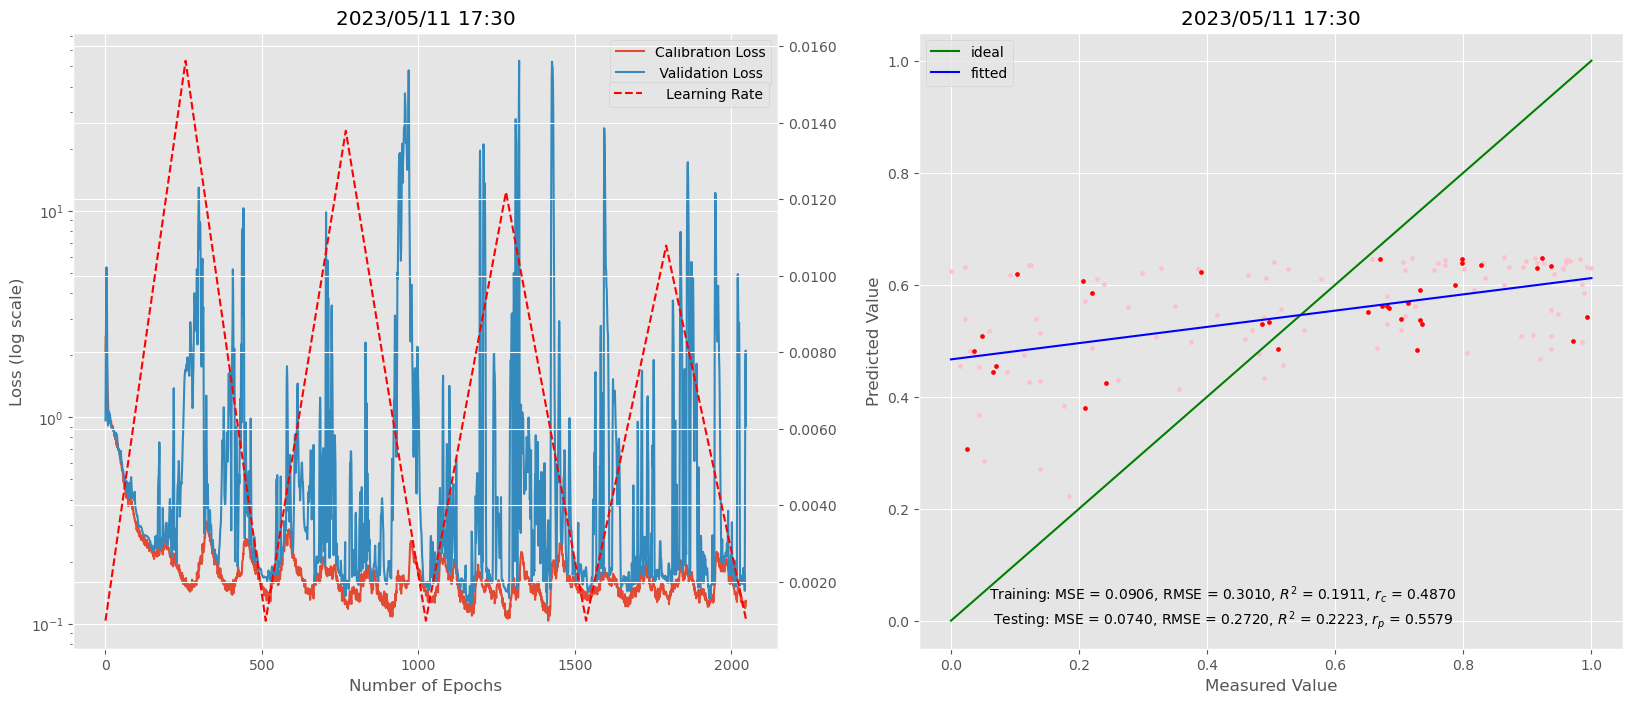

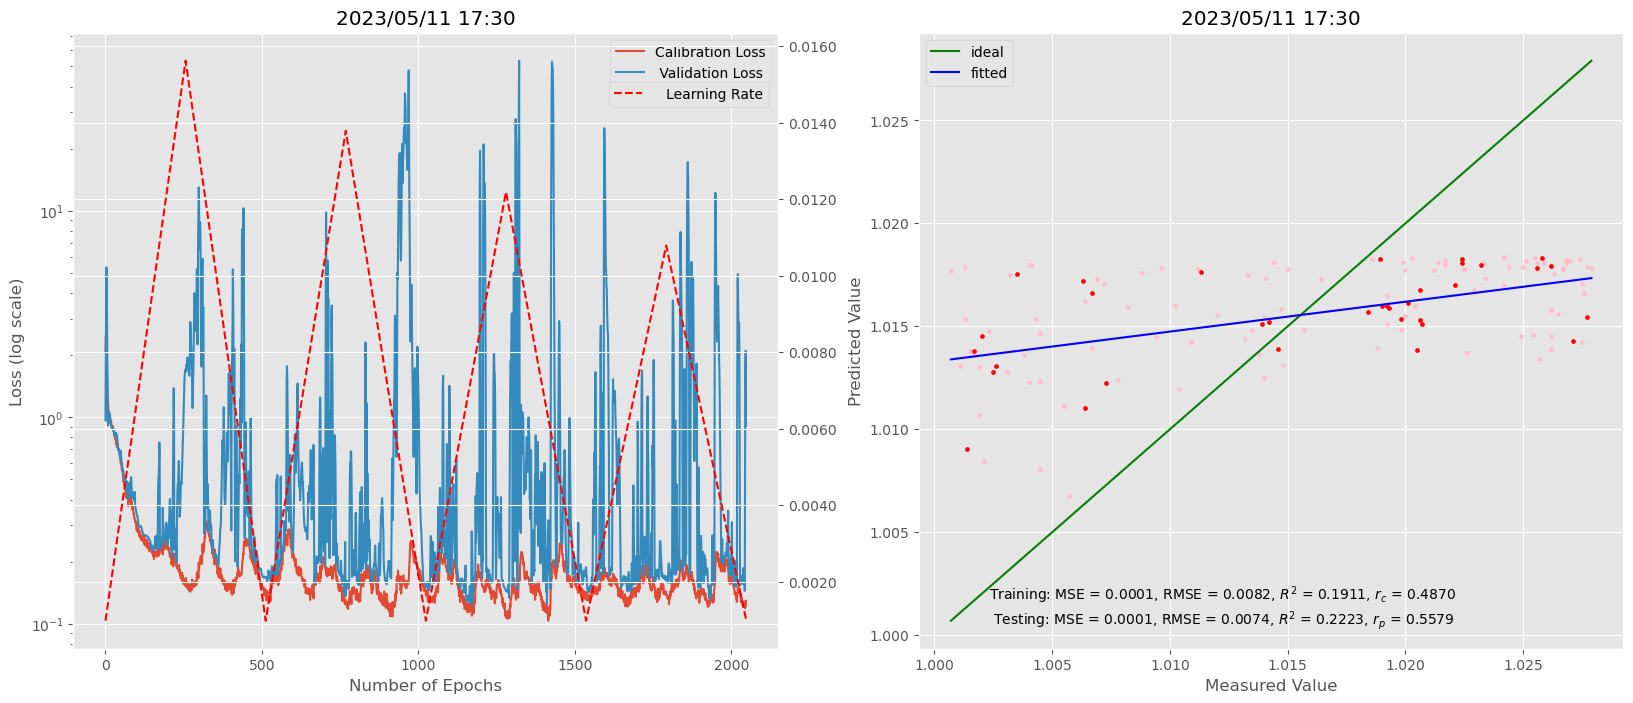

In [143]:
model.load_weights('model.h5')

Y_train_pred = model(X_train, training=False).numpy().squeeze()
Y_test_pred  = model(X_test , training=False).numpy().squeeze()

USG_train      = Y_train      * (max(USG) - min(USG)) + min(USG)
USG_test       = Y_test       * (max(USG) - min(USG)) + min(USG)

USG_train_pred = Y_train_pred * (max(USG) - min(USG)) + min(USG)
USG_test_pred  = Y_test_pred  * (max(USG) - min(USG)) + min(USG)

if 'lr' not in history.history: history.history['lr'] = CLR(range(len(history.history['loss'])))

plot_loss_and_prediction(history,   Y_train,   Y_train_pred,   Y_test,   Y_test_pred);
plot_loss_and_prediction(history, USG_train, USG_train_pred, USG_test, USG_test_pred);

## 9. Bayesian Optimization (BO) for Hyper-Parameters